# Control of  Buck converter with neural network

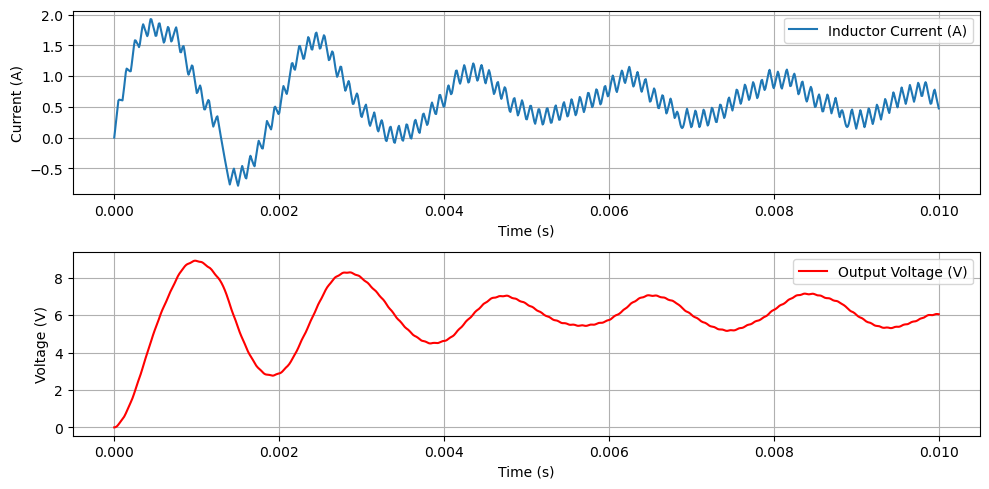

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
L = 1e-3  # Inductor (H)
C = 100e-6  # Capacitor (F)
R = 10  # Load resistance (Ohm)
Vin = 12  # Input voltage (V)
D = 0.5  # Duty cycle (50%)
T = 1e-4  # Switching period (s)

# State-space model
def buck_converter(t, x, u):
    iL, Vout = x  # State variables (Inductor current, Output voltage)
    
    diL_dt = (Vin * u - Vout) / L
    dVout_dt = (iL / C) - (Vout / (R * C))
    
    return [diL_dt, dVout_dt]

# Simulation settings
t_end = 0.01  # Simulation time (10ms)
ts = np.linspace(0, t_end, 1000)  # Time points

# Initial conditions
x0 = [0, 0]  # Initial inductor current and capacitor voltage

# Define control input (switching function)
def control_law(t):
    return 1 if (t % T) < (D * T) else 0

# Solve the system response
sol = solve_ivp(lambda t, x: buck_converter(t, x, control_law(t)), [0, t_end], x0, t_eval=ts)

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label='Inductor Current (A)')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[1], label='Output Voltage (V)', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Add pertubation

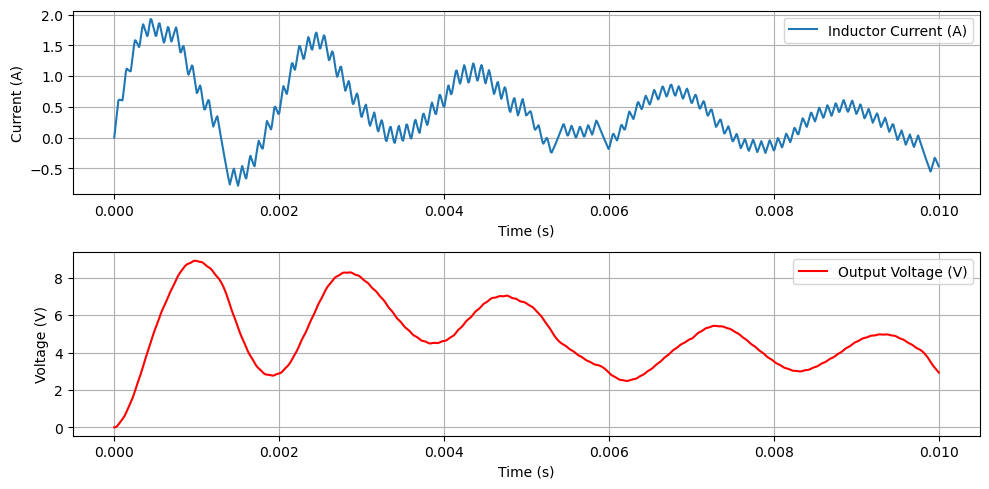

In [7]:


# State-space model
def buck_converter(t, x, u, Vin, R):
    iL, Vout = x  # State variables (Inductor current, Output voltage)
    
    diL_dt = (Vin * u - Vout) / L
    dVout_dt = (iL / C) - (Vout / (R * C))
    
    return [diL_dt, dVout_dt]

# Simulation settings
t_end = 0.01  # Simulation time (10ms)
ts = np.linspace(0, t_end, 1000)  # Time points

# Initial conditions
x0 = [0, 0]  # Initial inductor current and capacitor voltage

# Define control input (switching function)
def control_law(t):
    return 1 if (t % T) < (D * T) else 0

# Perturbation function
def perturb_system(t):
    Vin_perturbed = 12 if t < 5e-3 else 8  # Reduce Vin at t = 5ms
    R_perturbed = 10 if t < 7e-3 else 20  # Increase Load Resistance at t = 7ms
    return Vin_perturbed, R_perturbed

# Solve the system response
sol = solve_ivp(lambda t, x: buck_converter(t, x, control_law(t), *perturb_system(t)), [0, t_end], x0, t_eval=ts)

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label='Inductor Current (A)')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[1], label='Output Voltage (V)', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Training Data Format

In [8]:

import torch
from torch.utils.data import DataLoader, TensorDataset

# Define system parameters
L = 1e-3  # Inductor (H)
C = 1e-3  # Capacitor (F)
R_values = [10, 15, 20]  # Different load resistances
Vin_values = [8, 10, 12]  # Different input voltages
V_ref = 6  # Target output voltage

# Simulation parameters
dt = 1e-5  # Time step
T_sim = 0.01  # Total simulation time
num_steps = int(T_sim / dt)

# Storage for training data
X_train = []  # Inputs: (i_L, V_out)
Y_train = []  # Outputs: (Optimal D)

for R in R_values:
    for Vin in Vin_values:
        i_L = 0  # Initial inductor current
        V_out = 0  # Initial capacitor voltage
        
        for _ in range(num_steps):
            # Compute the best duty cycle for V_out -> V_ref
            if V_out < V_ref:
                D = min(1.0, (V_ref / Vin))  # Increase duty cycle
            else:
                D = max(0.0, (V_ref / Vin))  # Decrease duty cycle
            
            # Buck Converter State Update (Euler Integration)
            di_L = (Vin * D - V_out) / L * dt
            dv_out = (i_L - V_out / R) / C * dt
            
            i_L += di_L
            V_out += dv_out
            
            # Store (i_L, V_out) as input, D as output
            X_train.append([i_L, V_out])
            Y_train.append([D])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_train, Y_train)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Training dataset size: {len(X_train)} samples")


Training dataset size: 8991 samples


# neural network

In [17]:

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Neural Network Model
class BuckNN(nn.Module):
    def __init__(self):
        super(BuckNN, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Ensure duty cycle is between 0 and 1
        return x

# Initialize model, loss function, and optimizer
model = BuckNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

print("Neural Network training complete!")


Epoch 1/10, Loss: 0.010843
Epoch 2/10, Loss: 0.008885
Epoch 3/10, Loss: 0.010227
Epoch 4/10, Loss: 0.011628
Epoch 5/10, Loss: 0.009062
Epoch 6/10, Loss: 0.012546
Epoch 7/10, Loss: 0.013131
Epoch 8/10, Loss: 0.010261
Epoch 9/10, Loss: 0.011292
Epoch 10/10, Loss: 0.009804
Neural Network training complete!


# apply the neural network on the system

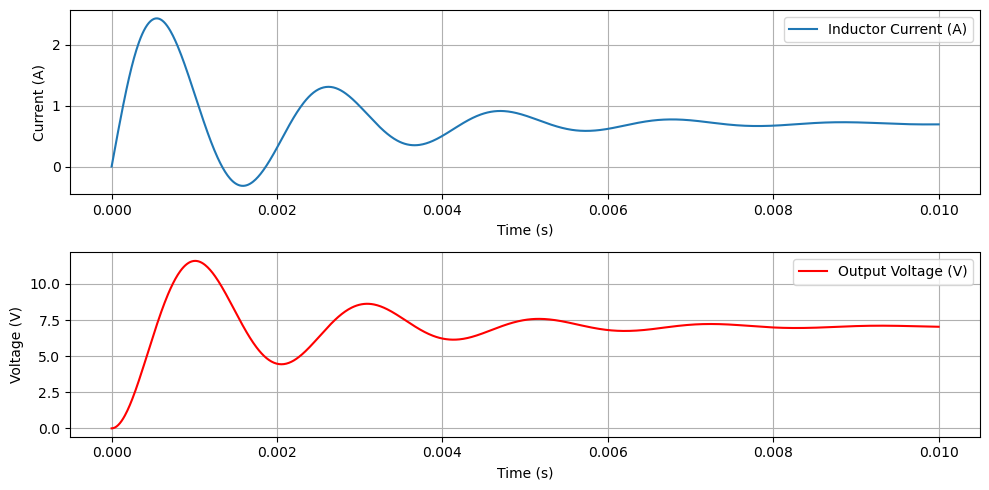

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Load trained model
model.eval()

def buck_converter_nn(t, x, Vin, R):
    iL, Vout = x
    
    # Convert state to tensor and predict duty cycle
    state = torch.tensor([[iL, Vout]], dtype=torch.float32)
    with torch.no_grad():
        D = model(state).item()
    
    diL_dt = (Vin * D - Vout) / L
    dVout_dt = (iL / C) - (Vout / (R * C))
    
    return [diL_dt, dVout_dt]

# Simulation settings
t_end = 0.01
ts = np.linspace(0, t_end, 1000)

# Initial conditions
x0 = [0, 0]

# Solve the system response using NN-based control
sol_nn = solve_ivp(lambda t, x: buck_converter_nn(t, x, Vin=12, R=10), [0, t_end], x0, t_eval=ts)

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(sol_nn.t, sol_nn.y[0], label='Inductor Current (A)')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sol_nn.t, sol_nn.y[1], label='Output Voltage (V)', color='r')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Evolution of Duty during the training

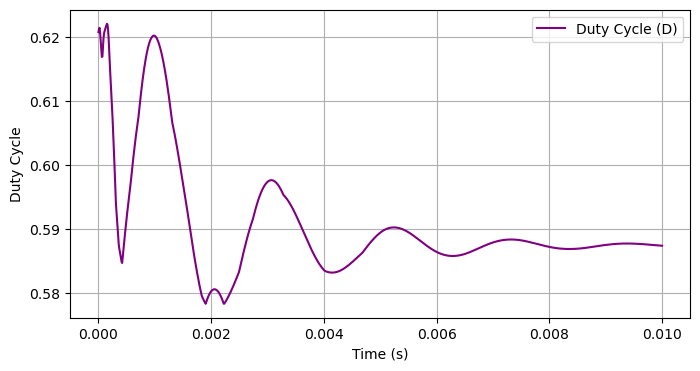

In [20]:
D_values = []
for i in range(len(sol_nn.t)):
    state = torch.tensor([[sol_nn.y[0][i], sol_nn.y[1][i]]], dtype=torch.float32)
    with torch.no_grad():
        D_values.append(model(state).item())

plt.figure(figsize=(8, 4))
plt.plot(sol_nn.t, D_values, label="Duty Cycle (D)", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Duty Cycle")
plt.legend()
plt.grid()
plt.show()
